### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode 
import pickle

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.preprocessing import StandardScaler, RobustScaler 

#Кластеризация
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.neighbors import KNeighborsClassifier

#понижение размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

#разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV


from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

from sklearn.ensemble import GradientBoostingRegressor 

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
matplotlib.rcParams.update({'font.size': 12})

#### Пути к директориям и файлам 

In [3]:
DATASET_PATH = './realestatepriceprediction/train.csv'
DATASET_PATH_TEST = './realestatepriceprediction/test.csv'
RESULT_PATH = './realestatepriceprediction/result.csv'

**Тренировочные данные**

In [4]:
df = pd.read_csv(DATASET_PATH, sep=',')
col_name = df.columns
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


**Тестовые данные**

In [5]:
test = pd.read_csv(DATASET_PATH_TEST)
test_col_names = test.columns
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


#### Анализ данных

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### Обработка пропусков<a class='anchor' id='nan'>

In [7]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [8]:
median_lifesquare = df['LifeSquare'].median()
df['LifeSquare'] = df['LifeSquare'].fillna(median_lifesquare)

In [9]:
mean_health = df['Healthcare_1'].mean()
df['Healthcare_1'] = df['Healthcare_1'].fillna(mean_health)

In [10]:
df['Shops_2'].unique()

array(['B', 'A'], dtype=object)

In [11]:
test.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [12]:
median_lifesquare_tst = test['LifeSquare'].median()
test['LifeSquare'] = test['LifeSquare'].fillna(median_lifesquare_tst)

In [13]:
mean_health_tst = test['Healthcare_1'].mean()
test['Healthcare_1'] = test['Healthcare_1'].fillna(mean_health_tst)

### Обработка выбросов<a class='anchor' id='outlier'>

In [14]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,36.266040,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,76.609981,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,736.734238,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1142.904460,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1142.904460,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [15]:
rooms_max = np.quantile(df['Rooms'], q=0.975)
rooms_min = np.quantile(df['Rooms'], q=0.025)
condition = (df['Rooms'] > rooms_max) | (df['Rooms'] < rooms_min)
df.loc[condition, 'Rooms'] = df['Rooms'].median()
df['Rooms'].describe()

count    10000.000000
mean         1.853000
std          0.756603
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: Rooms, dtype: float64

In [16]:
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,35.485549,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,15.915345,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,756.632091,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,25.850152,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,1146.657263,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,41.769526,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1146.657263,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [17]:
rooms_max_test = np.quantile(test['Rooms'], q=0.975)
rooms_min_test = np.quantile(test['Rooms'], q=0.025)
condition_test = (test['Rooms'] > rooms_max_test) | (test['Rooms'] < rooms_min_test)
test.loc[condition_test, 'Rooms'] = test['Rooms'].median()
test['Rooms'].describe()

count    5000.00000
mean        1.86600
std         0.74549
min         1.00000
25%         1.00000
50%         2.00000
75%         2.00000
max         3.00000
Name: Rooms, dtype: float64

In [18]:
square_max = np.quantile(df['Square'], q=0.995)
square_min = np.quantile(df['Square'], q=0.005)
condition = (df['Square'] > square_max) | (df["Square"] < square_min)
df.loc[condition, 'Square'] = df['Square'].median()
df['Square'].describe()

count    10000.000000
mean        55.841955
std         17.523351
min         27.245731
25%         41.891181
50%         52.513310
75%         65.687443
max        132.820646
Name: Square, dtype: float64

In [19]:
square_max_tst = np.quantile(test['Square'], q=0.995)
square_min_tst = np.quantile(test['Square'], q=0.005)
condition = (test['Square']  >square_max_tst) | (test['Square'] < square_min_tst)
test.loc[condition, 'Square'] = test['Square'].median()
test['Square'].describe()

count    5000.000000
mean       56.141582
std        17.491047
min        25.329567
25%        42.060114
50%        52.921340
75%        66.071191
max       132.670513
Name: Square, dtype: float64

In [20]:
lifesqr_max = np.quantile(df['LifeSquare'], q=0.995)
lifesqr_min = np.quantile(df['LifeSquare'], q=0.025)
df.loc[((df['LifeSquare'] > lifesqr_max) | (df['LifeSquare'] < lifesqr_min)), 'LifeSquare'] = df['LifeSquare'].median()
df['LifeSquare'].describe()

count    10000.000000
mean        35.604604
std         13.581837
min         15.146290
25%         27.982505
50%         32.781260
75%         41.145366
max        103.618474
Name: LifeSquare, dtype: float64

In [21]:
lifesqr_max_tst = np.quantile(test['LifeSquare'], q=0.995)
lifesqr_min_tst = np.quantile(test['LifeSquare'], q=0.025)
test.loc[((test['LifeSquare'] > lifesqr_max_tst) | (test['LifeSquare'] < lifesqr_min_tst)), 'LifeSquare'] = test['LifeSquare'].median()
test['LifeSquare'].describe()

count    5000.000000
mean       35.730776
std        13.449123
min        14.525566
25%        28.166227
50%        32.925087
75%        41.350476
max       102.194117
Name: LifeSquare, dtype: float64

In [22]:
df.loc[(df['Square'] < df['LifeSquare']), 'LifeSquare'] = df['LifeSquare'] - 10
df.loc[(df['Square'] < df['LifeSquare']), 'Square'] += df['Square'].median()

In [23]:
kitchsqr_max = np.quantile(df['KitchenSquare'], q=0.995)
df.loc[(df['KitchenSquare'] > kitchsqr_max), 'KitchenSquare'] = df['KitchenSquare'].median()
df.loc[(df['LifeSquare'] < df['KitchenSquare']), 'KitchenSquare'] = df['KitchenSquare'] - 15

In [24]:
test.loc[(test['Square'] < test['LifeSquare']), 'LifeSquare'] = test['LifeSquare'] - 10
test.loc[(test['Square'] < test['LifeSquare']), 'Square'] += test['Square'].median()

In [25]:
kitchsqr_max_tst = np.quantile(test['KitchenSquare'], q=0.995)
test.loc[(test['KitchenSquare'] > kitchsqr_max_tst), 'KitchenSquare'] = test['KitchenSquare'].median()
test.loc[(test['LifeSquare']  < test['KitchenSquare']), 'KitchenSquare'] = test['KitchenSquare'] - 15

In [26]:
floorhouse_min = np.quantile(df['HouseFloor'], q=0.027)
df.loc[(df['HouseFloor'] < df['Floor']), 'HouseFloor'] = np.quantile(df['HouseFloor'], q=0.85)
df.loc[(df['HouseFloor'] < df['Floor']), 'Floor'] = df['Floor'] - 10
df.loc[(df['HouseFloor'] < df['Floor']), 'Floor'] = df['Floor'] - 1

In [27]:
floorhouse_min_tst = np.quantile(test['HouseFloor'], q=0.027)
test.loc[(test['HouseFloor'] < test['Floor']), 'HouseFloor'] = np.quantile(test['HouseFloor'], q=0.85)
test.loc[(test['HouseFloor'] < test['Floor']), 'Floor'] = test['Floor'] - 10
test.loc[(test['HouseFloor'] < test['Floor']), 'Floor'] = test['Floor'] - 1

### Отбор и построение новых признаков<a class='anchor' id='feature'>

In [28]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.853000,55.915474,35.100604,5.674200,8.219600,14.583100,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.756603,17.619139,12.994767,3.871996,4.823951,5.543516,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,736.734238,1.493601,4.806341,92872.293865
min,0.00000,0.000000,1.000000,27.245731,15.146290,0.000000,1.000000,1.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.891181,27.465582,1.000000,4.000000,10.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,17.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1142.904460,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.774334,40.069919,9.000000,11.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1142.904460,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,3.000000,132.820646,103.618474,20.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [29]:
df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

**Количественные переменные**

In [30]:
# свободная площадь 
df['free_square'] = df['Square'] - (df['LifeSquare'] + df['KitchenSquare'])
df.loc[df['free_square'] < 0, 'Square'] = df['Square'] + 20 
df['free_square'] = df['Square'] - (df['LifeSquare'] + df['KitchenSquare'])

In [31]:
test['free_square'] = test['Square'] - (test['LifeSquare'] + test['KitchenSquare'])
test.loc[test['free_square']  < 0, 'Square'] = test['Square'] + 20
test['free_square'] = test['Square'] - (test['LifeSquare'] + test['KitchenSquare'])

In [32]:
# кол-во комнат на этаже 
df['count_rooms_on_the_floor'] = df['Floor'] / df['Rooms']
test['count_rooms_on_the_floor'] = test['Floor'] / test['Rooms']

In [33]:
# отношение кол-ва комнат к плащади 
df['relations_rooms_to_square'] = df['Square'] / df['Rooms']
test['relations_rooms_to_square'] = test['Square'] / test['Rooms']

**Категориальные переменные**<a class='anchor' id='category'>

In [34]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [35]:
df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix = 'Shops')], axis=1)
df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix = 'Ecology_2')], axis=1)
df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix = 'Ecology_3')], axis=1)
test = pd.concat([test, pd.get_dummies(test['Shops_2'], prefix = 'Shops')], axis=1)
test = pd.concat([test, pd.get_dummies(test['Ecology_2'], prefix = 'Ecology_2')], axis=1)
test = pd.concat([test, pd.get_dummies(test['Ecology_3'], prefix = 'Ecology_3')], axis=1)

### Уменьшение объема памяти, который занимает датасет**<a class='anchor' id='reduce'>

In [36]:
def reduce_mem_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [37]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.81 MB
Memory usage after optimization is: 0.83 MB
Decreased by 54.2%


In [38]:
df.dtypes

Id                              int16
DistrictId                      int16
Rooms                         float32
Square                        float32
LifeSquare                    float32
KitchenSquare                 float32
Floor                            int8
HouseFloor                    float32
HouseYear                       int32
Ecology_1                     float32
Ecology_2                    category
Ecology_3                    category
Social_1                         int8
Social_2                        int16
Social_3                        int16
Healthcare_1                  float32
Helthcare_2                      int8
Shops_1                          int8
Shops_2                      category
Price                         float32
free_square                   float32
count_rooms_on_the_floor      float32
relations_rooms_to_square     float32
Shops_A                       float32
Shops_B                       float32
Ecology_2_A                   float32
Ecology_2_B 

In [39]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 0.87 MB
Memory usage after optimization is: 0.39 MB
Decreased by 55.4%


# Распределение целевой переменнной

In [40]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]

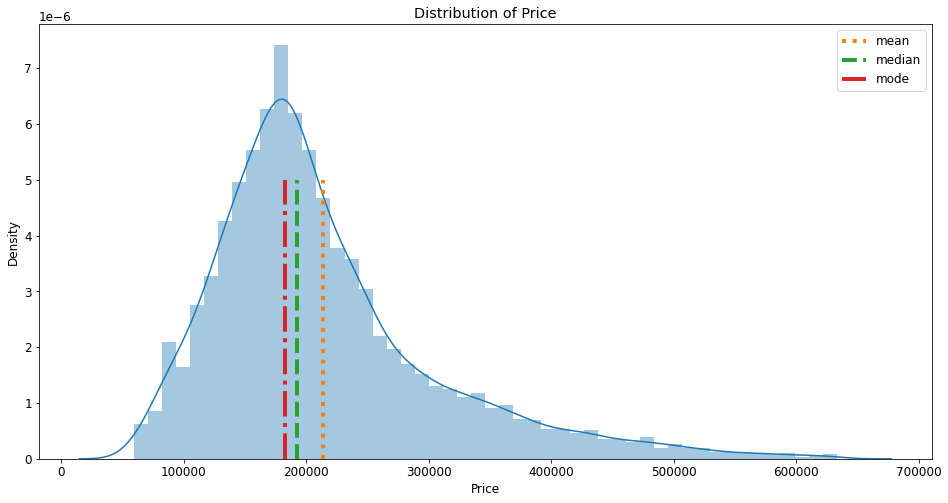

In [41]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode]  * 10, y, label = 'mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

# 2. Анализ признаков<a class='anchor' id='features'>

### 2.1 Количественные признаки<a class='anchor' id='num_features'>

In [42]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop('Price', axis=1, inplace=True)

In [43]:
df_num_features

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1,free_square,count_rooms_on_the_floor,relations_rooms_to_square,Shops_A,Shops_B,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B
0,2.0,47.981560,29.442751,6.0,9.0,0.089040,1142.904419,12.538811,3.500000,23.990780,0.0,1.0,0.0,1.0,0.0,1.0
1,3.0,65.683640,40.049541,8.0,9.0,0.000070,240.000000,17.634098,2.333333,21.894547,0.0,1.0,0.0,1.0,0.0,1.0
2,2.0,44.947952,29.197611,0.0,12.0,0.049637,229.000000,15.750341,4.000000,22.473976,0.0,1.0,0.0,1.0,0.0,1.0
3,2.0,73.352982,52.731510,9.0,17.0,0.437885,1084.000000,11.621469,4.000000,36.676491,0.0,1.0,0.0,1.0,0.0,1.0
4,1.0,39.649193,23.776169,7.0,12.0,0.012339,2078.000000,8.873023,11.000000,39.649193,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,50.401787,30.476204,5.0,17.0,0.135650,350.000000,14.925582,3.000000,25.200893,0.0,1.0,0.0,1.0,0.0,1.0
9996,1.0,41.521545,20.539215,9.0,13.0,0.000000,1142.904419,11.982330,13.000000,41.521545,1.0,0.0,0.0,1.0,0.0,1.0
9997,1.0,47.939007,32.781261,1.0,16.0,0.072158,1142.904419,14.157747,12.000000,47.939007,1.0,0.0,0.0,1.0,0.0,1.0
9998,2.0,43.602562,33.840149,8.0,5.0,0.307467,325.000000,1.762414,0.500000,21.801281,0.0,1.0,0.0,1.0,1.0,0.0


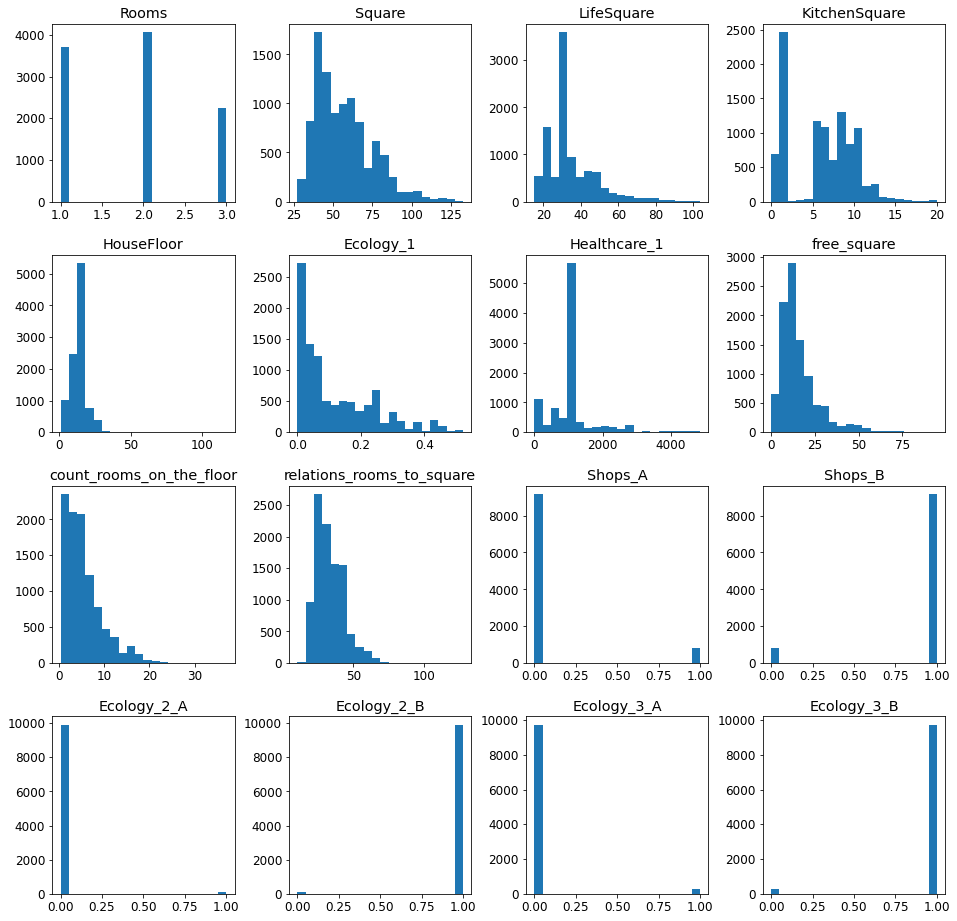

In [44]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

<AxesSubplot:>

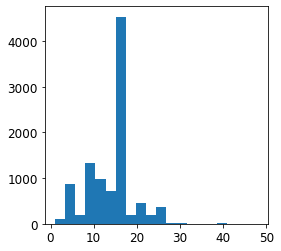

In [45]:
df.loc[df['HouseFloor'] < 50, 'HouseFloor'].\
    hist(figsize=(4,4), bins=20, grid=False)

In [46]:
df.loc[df['HouseFloor'] > 40, 'HouseFloor'] = df['HouseFloor'].median()

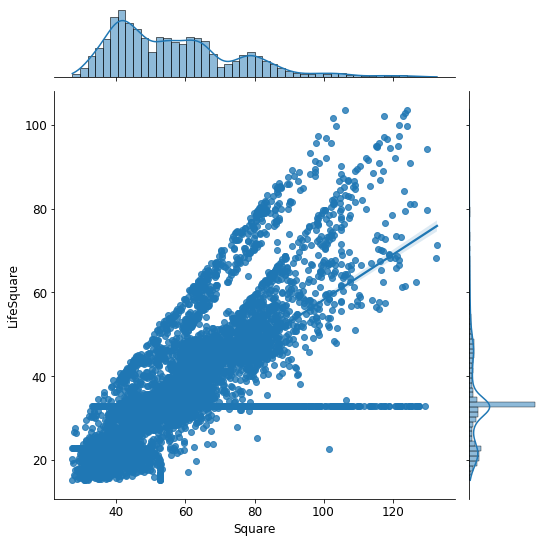

In [47]:
grid = sns.jointplot(df['Square'], df['LifeSquare'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

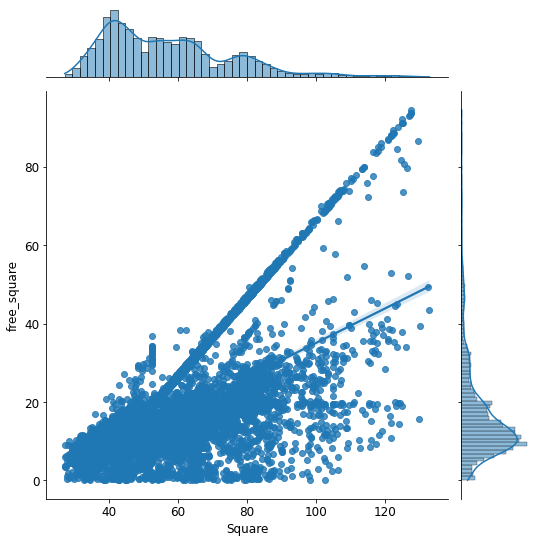

In [48]:
grid = sns.jointplot(df['Square'], df['free_square'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [49]:
df['Square'].value_counts()

52.513309     86
105.026619    13
81.867165      2
37.498161      2
80.794792      2
              ..
76.729919      1
56.984833      1
104.745209     1
55.278957      1
38.666645      1
Name: Square, Length: 9898, dtype: int64

In [50]:
df['free_square'].value_counts()

18.732050    30
19.732050    13
16.732050     6
13.732050     6
9.732050      3
             ..
18.668520     1
13.607534     1
2.326980      1
12.465547     1
9.508771      1
Name: free_square, Length: 9944, dtype: int64

**Поиск выбросов с помощью box plot**

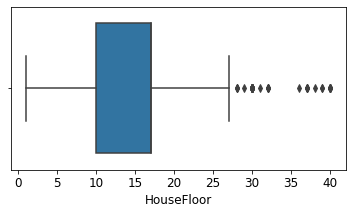

In [51]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['HouseFloor'], whis=1.5)

plt.xlabel('HouseFloor')
plt.show()

In [52]:
df.loc[df['HouseFloor'] > 25, 'HouseFloor'] = df['HouseFloor'].median()

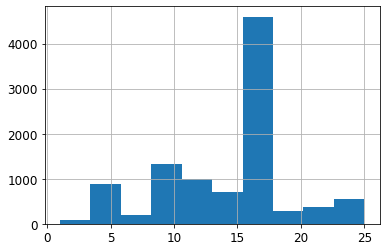

In [53]:
df['HouseFloor'].hist();

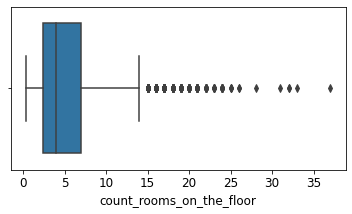

In [54]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['count_rooms_on_the_floor'], whis=1.5)

plt.xlabel('count_rooms_on_the_floor')
plt.show()

In [55]:
df.loc[df['count_rooms_on_the_floor'] > 14, 'count_rooms_on_the_floor'] = df['count_rooms_on_the_floor'].median()

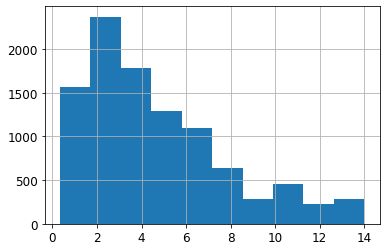

In [56]:
df['count_rooms_on_the_floor'].hist();

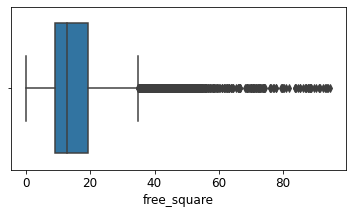

In [57]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['free_square'], whis=1.5)

plt.xlabel('free_square')
plt.show()

In [58]:
df.loc[df['free_square'] > 37, 'free_square'] = df['free_square'].median()

<AxesSubplot:>

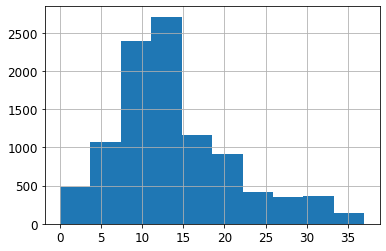

In [59]:
df['free_square'].hist()

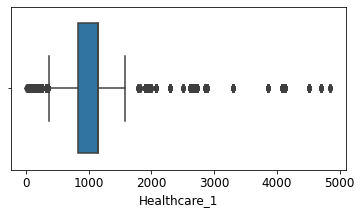

In [60]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Healthcare_1'], whis=1.5)

plt.xlabel('Healthcare_1')
plt.show()

In [61]:
df.loc[df['Healthcare_1'] > 1500, 'Healthcare_1'] = df['Healthcare_1'].median()

<AxesSubplot:>

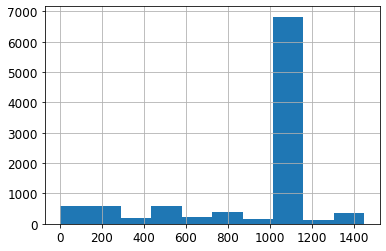

In [62]:
df['Healthcare_1'].hist()

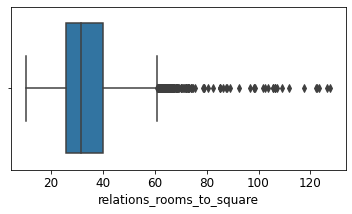

In [63]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['relations_rooms_to_square'], whis=1.5)

plt.xlabel('relations_rooms_to_square')
plt.show()

In [64]:
df.loc[df['relations_rooms_to_square'] > 60, 'relations_rooms_to_square'] = test['relations_rooms_to_square'].median()

### 2.4 Матрица корреляций<a class='anchor' id='corr'>

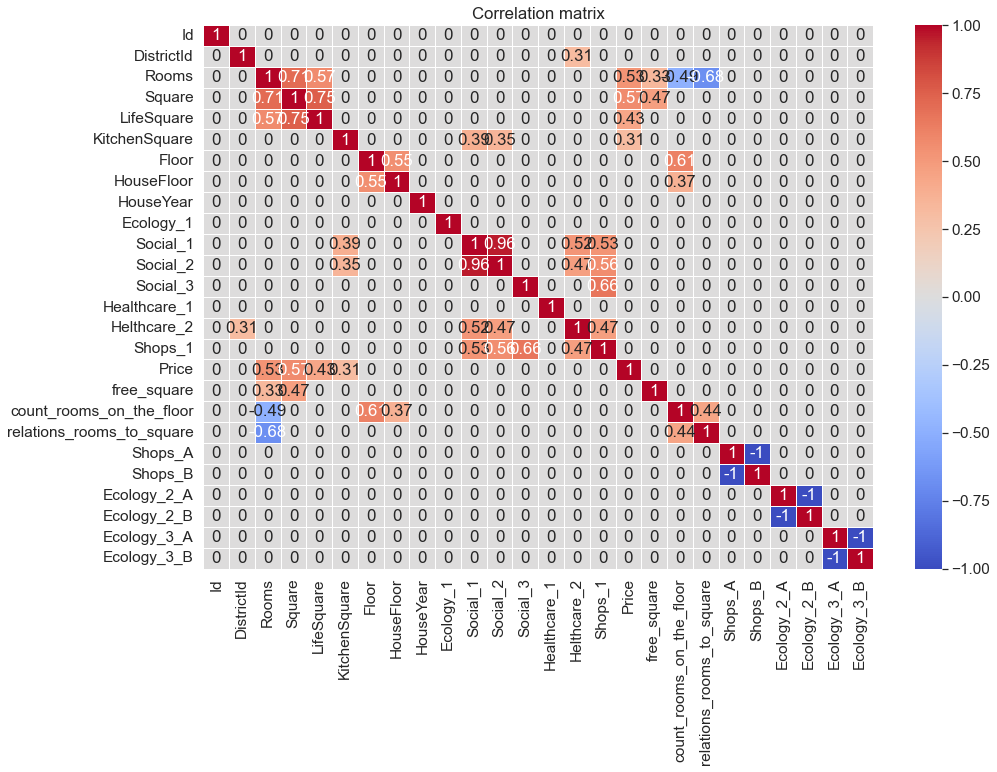

In [65]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

# 3. Анализ зависимости таргета от фичей<a class='anchor' id='target_features'>

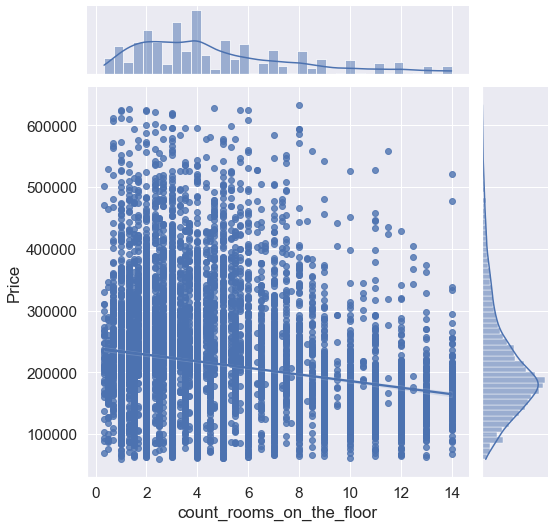

In [66]:
grid = sns.jointplot(df['count_rooms_on_the_floor'], df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

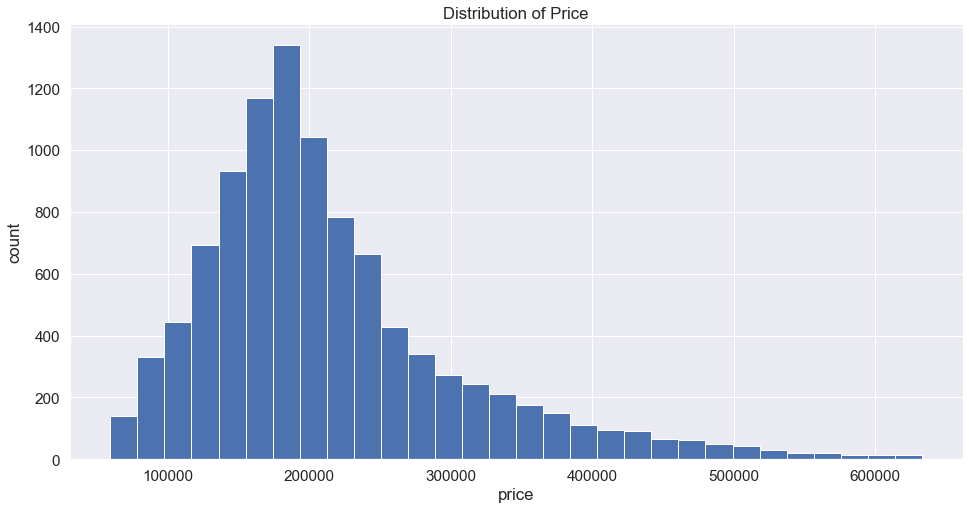

In [67]:
plt.figure(figsize = (16, 8))

df['Price'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('price')

plt.title('Distribution of Price')
plt.show()

**Оставим признаки, которые необходимы для модели**

In [68]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'free_square',
 'count_rooms_on_the_floor',
 'relations_rooms_to_square',
 'Shops_A',
 'Shops_B',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B']

In [69]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
                 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'free_square', 'count_rooms_on_the_floor',
                 'relations_rooms_to_square', 'Shops_A', 'Shops_B', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B']

target_name = 'Price'

In [70]:
df = df[feature_names + [target_name]]
test = test[feature_names + ['Id']]

In [71]:
df['Rooms'] = df['Rooms'].astype('int8')
test['Rooms'] = test['Rooms'].astype('int8')

In [72]:
df['HouseFloor'] = df['HouseFloor'].astype('int8')
test['HouseFloor'] = test['HouseFloor'].astype('int8')

In [73]:
df['count_rooms_on_the_floor'] = df['count_rooms_on_the_floor'].astype('int8')
test['count_rooms_on_the_floor'] = test['count_rooms_on_the_floor'].astype('int8')

In [74]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,free_square,count_rooms_on_the_floor,relations_rooms_to_square,Shops_A,Shops_B,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Price
0,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,33,...,12.538811,3,23.990780,0.0,1.0,0.0,1.0,0.0,1.0,184966.937500
1,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,46,...,17.634098,2,21.894547,0.0,1.0,0.0,1.0,0.0,1.0,300009.437500
2,53,2,44.947952,29.197611,0.0,8,12,1968,0.049637,34,...,15.750341,4,22.473976,0.0,1.0,0.0,1.0,0.0,1.0,220925.906250
3,58,2,73.352982,52.731510,9.0,8,17,1977,0.437885,23,...,11.621469,4,36.676491,0.0,1.0,0.0,1.0,0.0,1.0,175616.234375
4,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,35,...,8.873023,11,39.649193,0.0,1.0,0.0,1.0,0.0,1.0,150226.531250


In [75]:
df.dtypes

DistrictId                     int16
Rooms                           int8
Square                       float32
LifeSquare                   float32
KitchenSquare                float32
Floor                           int8
HouseFloor                      int8
HouseYear                      int32
Ecology_1                    float32
Social_1                        int8
Social_2                       int16
Social_3                       int16
Healthcare_1                 float32
Helthcare_2                     int8
Shops_1                         int8
free_square                  float32
count_rooms_on_the_floor        int8
relations_rooms_to_square    float32
Shops_A                      float32
Shops_B                      float32
Ecology_2_A                  float32
Ecology_2_B                  float32
Ecology_3_A                  float32
Ecology_3_B                  float32
Price                        float32
dtype: object

**Стандартизация признаков** 

In [76]:
feature_names_for_stand = df[feature_names].select_dtypes(include=['float32']).columns.tolist()
feature_names_for_stand

['Square',
 'LifeSquare',
 'KitchenSquare',
 'Ecology_1',
 'Healthcare_1',
 'free_square',
 'relations_rooms_to_square',
 'Shops_A',
 'Shops_B',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B']

In [77]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])
stand_features_tst = scaler.transform(test[feature_names_for_stand])

In [78]:
stand_features

array([[-0.49237227, -0.43541652,  0.08414686, ...,  0.09896976,
        -0.16815954,  0.16815954],
       [ 0.4863047 ,  0.3808598 ,  0.6007021 , ...,  0.09896976,
        -0.16815954,  0.16815954],
       [-0.66008824, -0.454282  , -1.465519  , ...,  0.09896976,
        -0.16815954,  0.16815954],
       ...,
       [-0.49472484, -0.17849179, -1.2072413 , ...,  0.09896976,
        -0.16815954,  0.16815954],
       [-0.7344695 , -0.09700204,  0.6007021 , ...,  0.09896976,
         5.9467335 , -5.9467335 ],
       [-1.0073565 , -1.0730032 ,  0.6007021 , ...,  0.09896976,
        -0.16815954,  0.16815954]], dtype=float32)

In [79]:
stand_features_tst

array([[-0.3872689 , -0.1283522 ,  0.08414686, ...,  0.09896976,
        -0.16815954,  0.16815954],
       [ 0.6842033 , -0.16742328, -1.2072413 , ...,  0.09896976,
        -0.16815954,  0.16815954],
       [-0.21927159, -1.4739254 ,  1.6338127 , ...,  0.09896976,
        -0.16815954,  0.16815954],
       ...,
       [ 1.1585015 ,  1.0144604 ,  0.85897976, ...,  0.09896976,
        -0.16815954,  0.16815954],
       [ 1.3499593 , -0.16742328, -1.465519  , ...,  0.09896976,
        -0.16815954,  0.16815954],
       [ 0.2028012 , -0.16742328, -1.2072413 , ...,  0.09896976,
        -0.16815954,  0.16815954]], dtype=float32)

In [80]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
test[feature_names_for_stand] = pd.DataFrame(stand_features_tst, columns=feature_names_for_stand)

In [81]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,free_square,count_rooms_on_the_floor,relations_rooms_to_square,Shops_A,Shops_B,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Price
0,35,2,-0.492372,-0.435417,0.084147,7,9,1969,-0.250529,33,...,-0.166912,3,-0.978264,-0.299864,0.299864,-0.09897,0.09897,-0.16816,0.16816,184966.937500
1,41,3,0.486305,0.380860,0.600702,7,9,1978,-0.998053,46,...,0.537514,2,-1.215741,-0.299864,0.299864,-0.09897,0.09897,-0.16816,0.16816,300009.437500
2,53,2,-0.660088,-0.454282,-1.465519,8,12,1968,-0.581588,34,...,0.277084,4,-1.150099,-0.299864,0.299864,-0.09897,0.09897,-0.16816,0.16816,220925.906250
3,58,2,0.910312,1.356837,0.858980,8,17,1977,2.680470,23,...,-0.293735,4,0.458867,-0.299864,0.299864,-0.09897,0.09897,-0.16816,0.16816,175616.234375
4,99,1,-0.953035,-0.871505,0.342424,11,12,1976,-0.894969,35,...,-0.673709,11,0.795637,-0.299864,0.299864,-0.09897,0.09897,-0.16816,0.16816,150226.531250


# Шаг 4. Разбиение на train / test

In [82]:
X = df[feature_names]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [83]:
def evaluate_preds(true_values, pred_values, save=False):
    '''Оценка качества модели и график preds vs true'''
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
         "EMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" + 
         "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8, 8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black') # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    plt.show()

# Шаг 6.** Настройка и оценка финальной модели

In [84]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     min_samples_leaf=10,
                                     random_state=42,
                                    # n_estimators=100,
                                    # max_depth=7
                                    )

In [85]:
%%time
params = {'n_estimators':[50, 100, 200, 400],
          'max_depth': [3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params,
                 scoring='r2',
                 cv=KFold(n_splits=5,
                          random_state=21,
                          shuffle=True),
                 n_jobs=-1
                 )
gs.fit(X_train, y_train)

CPU times: total: 5.66 s
Wall time: 1min 29s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 min_samples_leaf=10,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [86]:
res = pd.DataFrame(gs.cv_results_)
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.129475,0.029119,0.008693,0.006469,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.675628,0.690533,0.663794,0.667036,0.691066,0.677611,0.011443,16
1,1.700842,0.183548,0.004432,0.004663,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.703748,0.728185,0.691849,0.693881,0.715031,0.706539,0.013597,10
2,3.515328,0.191606,0.005221,0.004329,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.717826,0.743945,0.705185,0.714312,0.727865,0.721827,0.013229,5
3,6.620335,0.308932,0.045369,0.051413,3,400,"{'max_depth': 3, 'n_estimators': 400}",0.723039,0.755680,0.711318,0.721674,0.725954,0.727533,0.014914,2
4,1.255655,0.209214,0.006831,0.004145,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.710090,0.738310,0.700688,0.712956,0.713060,0.715021,0.012492,6


In [87]:
gs.best_params_

{'max_depth': 5, 'n_estimators': 200}

In [88]:
gs.best_score_

0.7295642514951429

**Обучение и оценка модели**

R2:	0.981
EMSE:	12723.223
MSE:	161880404.752


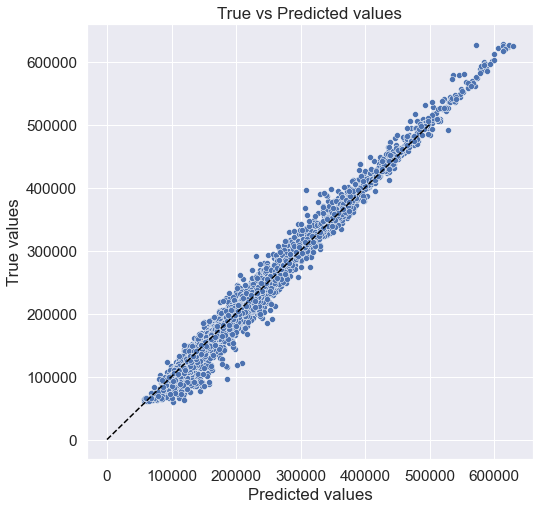

In [89]:
final_model = CatBoostRegressor( silent=True,
                                learning_rate=0.1,
                                iterations=1150,
                                eval_metric='R2',
                                depth=8)

final_model.fit(X_train, y_train)

y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.728
EMSE:	48369.631
MSE:	2339621237.425


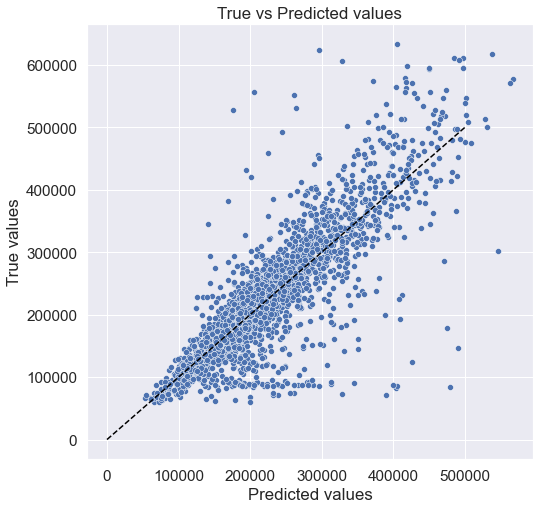

In [90]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds, save=True)

In [91]:
preds_final = pd.DataFrame()
preds_final['Id'] = test['Id'].copy()

test.set_index('Id', inplace=True)
test = test[feature_names]

In [92]:
y_pred_final = final_model.predict(test)
preds_final['Price'] = y_pred_final
preds_final.to_csv(RESULT_PATH ,index=False, encoding='utf-8', sep=',')

preds_final.head()

,Id,Price
0,725,156319.323992
1,15856,221194.062030
2,5480,219964.570681
3,15664,317073.096978
4,14275,147720.635090


# Шаг 7.* Анализ прогнозов

**Важность признаков**

In [93]:
final_model.feature_importances_

array([7.80102457e+00, 3.17676245e+00, 1.82501014e+01, 4.15075664e+00,
       5.19915250e+00, 3.11055966e+00, 2.74567563e+00, 6.50309756e+00,
       7.24578735e+00, 6.99970518e+00, 6.66223463e+00, 9.72741520e+00,
       2.09229891e+00, 2.52507016e+00, 2.74637743e+00, 4.48156175e+00,
       1.39468514e+00, 4.53924976e+00, 2.89098869e-01, 8.69179334e-02,
       1.46643528e-02, 1.43621385e-02, 1.10077475e-01, 1.33363260e-01])

In [94]:
feature_importances = pd.DataFrame(zip(X_train.columns,
                                      final_model.feature_importances_),
                                  columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [95]:
feature_importances

,feature_name,importance
2,Square,18.250101
11,Social_3,9.727415
0,DistrictId,7.801025
8,Ecology_1,7.245787
9,Social_1,6.999705
10,Social_2,6.662235
7,HouseYear,6.503098
4,KitchenSquare,5.199152
17,relations_rooms_to_square,4.539250
15,free_square,4.481562
